In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from typing import TypedDict, List, Annotated, Optional, Dict, Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
import operator
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.types import interrupt, Command

In [ ]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")

when in future we will store one best mail and tweak based on company name and all 

In [ ]:
class EmailState(TypedDict, total=False):
    sender_name: str
    receiver_name: str
    role: str
    context: str
    resume: str
    iteration: int
    max_iteration: int
    email_history: Annotated[List[str], operator.add]
    selected_mail: str
    status: Literal["success", "cancelled"]

In [ ]:
def generate_email(state: EmailState):
    
    system_prompt = (
        f"You are a senior recruiter hiring for {state['role']} roles. "
        "Write short, achievement-focused outreach emails under 150 words."
    )
    human_prompt = (
        f"Role: {state['role']}\n"
        f"Context: {state['context']}\n"
        f"Sender: {state['sender_name']}\n"
        f"Receiver: {state['receiver_name']}\n"
        f"Resume: {state['resume']}"
    )
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt)
    ])
    email_text = response.content.strip()
    state["email_history"] = state.get("email_history", []) + [email_text]
    state["iteration"] = state.get("iteration", 0) + 1

    return state

condtion to generate mail

In [ ]:
def loop_condition(state: EmailState) -> EmailState:
    while state["iteration"] < state["max_iteration"]:
        state = generate_email(state)
    return state

In [ ]:
# ----------------------------
# USER SELECT EMAIL
# ----------------------------

def select_email(state: EmailState) -> EmailState:
    print("\n------ GENERATED EMAILS ------\n")
    for i, mail in enumerate(state["email_history"]):
        print(f"Email {i+1}:\n{mail}\n")
    
    choice = interrupt("Select email number (0-4): ")
    state["selected_mail"] = state["email_history"][int(choice)]
    return state
 

In [ ]:
#tool to make is this email work
@tool
def check_email(email : str) -> dict:

    """
    Simulate sending a decision to post email or not.
    HUMAN-IN-THE-LOOP:
    Before confirming the purchase, this tool will interrupt
    and wait for a human decision ("yes" / anything else).
    """

    decision = interrupt(f"Approve sending this {email}? (yes/no)")

    if isinstance(decision, str) and decision.lower() == "yes":
        return {"status": "success"}
    else:
        return {"status": "cancelled"}

code that sends email

In [ ]:
import smtplib
from email.mime.text import MIMEText

def send_email(to_email : str, subject : str, content : str):
    sender_email = "sameple@gmail.com"
    sender_password = "password"
    
    msg = MIMEText(content)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = to_email

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(sender_email, sender_password)
        server.sendmail(sender_email, to_email, msg.as_string())
    
    return "EMAIL SENT SUCCESSFULLY"


In [ ]:
@tool
def send_email_tool(to_email : str, subject : str, content : str, status : str) -> dict:
    """
    Sends email only if status is success.
    """ 
    if status == "success":
        return send_email(to_email, subject, content)
    else:
        return "EMAIL NOT SENT"

In [ ]:
def approve_node(state: EmailState):
    result = check_email.invoke({"email": state["selected_mail"]})
    state["status"] = result["status"]
    return state

In [ ]:
def send_node(state: EmailState):

    result = send_email_tool.invoke({
        "to_email": "receiver@example.com",
        "subject": f"Application for {state['role']}",
        "content": state["selected_mail"],
        "status": state["status"]
    })

    print(result)
    return state

In [ ]:
from database import checkpointer

In [ ]:
graph = StateGraph(EmailState)
graph.add_node("generate_email", generate_email)
graph.add_node("select_email", select_email)
graph.add_node("approve_node", approve_node)
graph.add_node("send_node", send_node)

graph.add_edge(START, "generate_email")
graph.add_conditional_edges("generate_email", loop_condition)
graph.add_edge("select_email", "approve_node")
graph.add_edge("approve_node", "send_node")
graph.add_edge("send_node", END)

workflow = graph.compile(checkpointer=checkpointer)

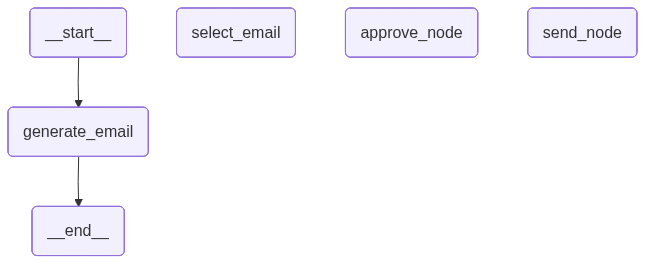

In [19]:
workflow

In [ ]:
initial_state = {
    "sender_name": "Ayush",
    "receiver_name": "Hiring Manager",
    "role": "AI Intern",
    "context": "Built RAG systems and LangGraph workflows.",
    "resume": "https://resume-link.com",
    "iteration": 0,
    "max_iteration": 5
}
config = {
    "configurable":{
        "thread_id" : "job_agent:ayush:EMAIL:ENGINEER"
    }
}
workflow.invoke(initial_state, config=config)